In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
from __future__ import annotations
import networkx as nx
import jaxley as jx
from jaxley.io.swc import read_swc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# TODOS:

### change order of nodes and edges
- Nodes: idx, indices (int), groups (bool), morph_attrs, channel_attrs, other_attrs (set_by)
- Edges: idx, indices (int), synapses (bool), morph_attrs, channel_attrs, other_attrs (set_by)

### Reformat dataframes
- rename `global_X_index` to `X_index`
- use tuples of nodes to index edges
- treat synapses like groups and channels, i.e. boolean indices

### Pass tests
- pass import / export cycle tests
- pass `test_swc.py`

### Remove group_names from global graph attrs
- group_names can be inferred from nodes, i.e. names of boolean cols which are not channels.


### Keep branchpoints and tip nodes in `nodes` and in graph
- introduce `compartments` attribute that only shows compartment nodes? Nodes shows all nodes `cell.nodes.loc[is_comp]`

### Refactor graph editing functions in `morph_utils`
- with the new graph functionality, this should be much easier to do

### Refactor `compute_xyz` function
- replace old `compute_xyz` with new version

### Refactor `set_ncomp`
- `set_ncomp` should be much simpler via `branch_comps_from_nodes`

In [4]:
import jaxley.io.graph as graph_io_old
import jaxley.io.tmp as graph_io_new

import networkx as nx
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import jax

import warnings

In [5]:
def graph_vis(graph, dims=(0, 1), ax=None, show_radii=False, jitter=0.0, radii_scale=1.0, radii_kwargs={}, **kwargs):
    import matplotlib.pyplot as plt
    import networkx as nx
    from matplotlib.patches import Circle

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    dim2str = {0: "x", 1: "y", 2: "z"}
    np.random.seed(42)
    pos = {
        k: tuple(
            d.get(dim2str[dim], 0.0) + (np.random.uniform(-jitter, jitter) if jitter > 0 else 0.0)
            for dim in dims
        )
        for k, d in graph.nodes(data=True)
    }

    nx.draw(graph, pos=pos, ax=ax, **kwargs)

    if show_radii:
        patch_kwargs = dict(edgecolor="C3", facecolor="none", linewidth=1.0, alpha=0.8, zorder=3)
        patch_kwargs.update(radii_kwargs)

        for k, data in graph.nodes(data=True):
            r = data.get("radius", data.get("r", None))
            if r is None:
                continue
            R = float(r) * float(radii_scale)
            x, y = pos[k]
            ax.add_patch(Circle((x, y), R, **patch_kwargs))

        ax.set_aspect("equal", adjustable="box")

    return ax

In [316]:
import numpy as np
from neuron import h
from neuron import rxd
from matplotlib.lines import Line2D
import jaxley.io.graph as graph_io_old
import jaxley.io.tmp as graph_io_new
from scipy.spatial.distance import cdist

import pandas as pd

unpack_dict = lambda d, keys: np.array([d[k] for k in keys])

def neuron_swc_reader(fname, ncomp=1):
    # Load NEURON stdlib and import3d
    h.load_file("stdlib.hoc")
    h.load_file("import3d.hoc")

    # Clear existing sections
    for sec in h.allsec():
        h.delete_section(sec=sec)

    # Load and instantiate SWC
    cell = h.Import3d_SWC_read()
    cell.input(fname)
    i3d = h.Import3d_GUI(cell, False)
    i3d.instantiate(None)

    for sec in h.allsec():
        sec.nseg = ncomp

    return cell


def neuron_swc_graph(fname):
    # cell = neuron_swc_reader(fname)

    points = []
    id_counter = 1  # SWC IDs start at 1

    # Map section types to SWC type IDs
    type_map = {
        'soma': 1,
        'axon': 2,
        'dend': 3,
        'apic': 4
    }

    # Keep track of last point ID in each section for connectivity
    section_last_point_id = {}

    for sec in h.allsec():
        sec_name = sec.name()
        # Determine SWC type by checking the prefix of section name
        swc_type = 3  # default dendrite
        for key in type_map:
            if sec_name.startswith(key):
                swc_type = type_map[key]
                break

        n3d = int(h.n3d(sec=sec))
        if n3d == 0:
            continue

        for i in range(n3d):
            x = h.x3d(i, sec=sec)
            y = h.y3d(i, sec=sec)
            z = h.z3d(i, sec=sec)
            radius = h.diam3d(i, sec=sec) / 2

            if i == 0:
                # Parent id is the last point id of the parent section if exists
                sec_ref = h.SectionRef(sec=sec)
                if sec_ref.has_parent():
                    parent_sec = sec_ref.parent
                    parent_point_id = section_last_point_id.get(parent_sec.name(), -1)
                else:
                    parent_point_id = -1
            else:
                # Parent is previous point in the same section
                parent_point_id = id_counter - 1

            points.append({
                'node': id_counter,
                'id': swc_type,
                'x': x,
                'y': y,
                'z': z,
                'r': radius,
                'parent_id': parent_point_id,
                'sec_name': sec_name,
            })
            id_counter += 1

        # Save last point id of this section for parent linkage
        section_last_point_id[sec_name] = id_counter - 1

    # Convert to DataFrame or whatever format you prefer
    nodes_df = pd.DataFrame(points)
    nodes_df.set_index("node", inplace=True)
    nodes_df.index.name = None

    edges_df = nodes_df[["parent_id"]].copy()
    edges_df["target"] = nodes_df.index
    edges_df = edges_df[edges_df["parent_id"] != -1]
    edges_df.set_index(["parent_id", "target"], inplace=True)
    edges_df.index.names = (None, None)

    nodes_df.drop(columns=["parent_id"], inplace=True)

    return graph_io_new.pandas_to_nx(nodes_df, edges_df, pd.Series())


def neuron_comp_graph(fname, ncomp=1):
    # cell = neuron_swc_reader(fname, ncomp)

    data = []
    segment_indices = {}
    compartment_index = 0

    # Mapping from section prefix to group label
    type2group = {
        "soma": "soma",
        "axon": "axon",
        "dend": "basal",
        "apic": "apical"
    }

    # Example cytosolic region
    cyt = rxd.Region(h.allsec(), name='cyt')

    # Create a dummy species to get access to segment volumes
    ca = rxd.Species(cyt, name='ca', d=0)

    seg_surface_areas = {str(node.segment): node.surface_area for node in ca.nodes}
    seg_volumes = {str(node.segment): node.volume for node in ca.nodes}

    # First pass: collect node data and assign segment indices
    for sec in h.allsec():
        centers = np.linspace(0, 1, 2*sec.nseg+1)[1:-1:2]
        sec_name = sec.name()

        segment_indices[sec] = []

        for seg_idx, seg in enumerate(sec):
            x = seg.x
            pt3d_sec = h.SectionRef(sec=sec).sec
            n3d = int(h.n3d(sec=pt3d_sec))

            if n3d < 2:
                continue

            arc_lengths = [h.arc3d(i, sec=pt3d_sec) for i in range(n3d)]
            xs = [h.x3d(i, sec=pt3d_sec) for i in range(n3d)]
            ys = [h.y3d(i, sec=pt3d_sec) for i in range(n3d)]
            zs = [h.z3d(i, sec=pt3d_sec) for i in range(n3d)]

            total_length = arc_lengths[-1]
            target = x * total_length

            for i in range(n3d - 1):
                if arc_lengths[i] <= target <= arc_lengths[i + 1]:
                    denom = arc_lengths[i + 1] - arc_lengths[i]
                    if denom == 0:
                        # Use midpoint or skip (depending on your preference)
                        seg_x_pos = xs[i]
                        seg_y_pos = ys[i]
                        seg_z_pos = zs[i]
                    else:
                        frac = (target - arc_lengths[i]) / denom
                        seg_x_pos = xs[i] + frac * (xs[i + 1] - xs[i])
                        seg_y_pos = ys[i] + frac * (ys[i + 1] - ys[i])
                        seg_z_pos = zs[i] + frac * (zs[i + 1] - zs[i])
                    break
            else:
                seg_x_pos = xs[-1]
                seg_y_pos = ys[-1]
                seg_z_pos = zs[-1]

            radius = seg.diam / 2
            area = h.area(x, sec=sec)
            length = sec.L / sec.nseg
            type_name = sec_name.split("[")[0]
            seg_name = str(sec(centers[seg_idx]))

            data.append({
                "comp_index": compartment_index,
                "seg_name": str(sec(centers[seg_idx])),
                "sec_name": sec_name,
                "x": seg_x_pos,
                "y": seg_y_pos,
                "z": seg_z_pos,
                "radius": radius,
                "area": area,
                "surface_area": seg_surface_areas[seg_name],
                "volume": seg_volumes[seg_name],
                "length": length,
                "groups": [type2group.get(type_name, "unknown")]
            })

            segment_indices[sec].append(compartment_index)
            compartment_index += 1

    # Build edge list
    seg_edges = [(str(s.parentseg().sec) if s.parentseg() else None, str(s)) for s in h.allsec()]

    # Create DataFrames
    nodes_df = pd.DataFrame(data).set_index("comp_index")
    edges_df = pd.DataFrame(seg_edges, columns=["source", "target"])
    edges_df = edges_df[edges_df["source"].notna()]

    name_to_index = dict(zip(nodes_df["sec_name"], nodes_df.index))
    edges_df['source'] = edges_df['source'].map(name_to_index)
    edges_df['target'] = edges_df['target'].map(name_to_index)
    edges_df.set_index(["source", "target"], inplace=True)
    edges_df.index.names = [None, None]

    return graph_io_new.pandas_to_nx(nodes_df, edges_df, pd.Series())

def neuron_list_branches(swc_neuron):
    nodes_df, edges_df, global_attrs = graph_io_new.nx_to_pandas(swc_neuron)
    nodes_xyzr = np.array([unpack_dict(d, "xyzr") for n,d in swc_neuron.nodes(data=True)])
    node_order = {i: n for i, n in enumerate(swc_neuron.nodes())}
    
    branches = []
    for sec_name, group in nodes_df.groupby("sec_name"):
        branch = []
        for node_xyzr in group[["x", "y", "z", "r"]].values:
            min_idx = np.argmin(np.linalg.norm(nodes_xyzr - node_xyzr, axis=1))
            branch.append(node_order[min_idx])
        branches.append(branch)
    return branches

def old_list_branches(swc_graph, ignore_swc_tracing_interruptions=True):
    traced_branches = []
    mod_graph, branches, *_ = graph_io_old._trace_branches(swc_graph, ignore_swc_tracing_interruptions=ignore_swc_tracing_interruptions)
    for branch in branches:
        traced_branches.append(np.unique(branch[:,:-1].flatten().astype(int)).tolist())
    return traced_branches, mod_graph

def match_branches(swc_graph_input, swc_graph_target, input_branches, target_branches):
    assert len(input_branches) == len(target_branches), "Number of branches is not the same"
    
    metrics = ["center", "mean", "len"]
    cache = {"input": {m: [] for m in metrics}, "target": {m: [] for m in metrics}}

    for key, branches, graph in zip(["input", "target"], [input_branches, target_branches], [swc_graph_input, swc_graph_target]):
        for branch in branches:
            branch_xyzr = np.array([unpack_dict(graph.nodes[n], "xyzr") for n in branch])
            branch_arc_lens = np.concatenate([[0], np.cumsum(np.linalg.norm(np.diff(branch_xyzr[:, :3], axis=0), axis=1))])
            branch_center = np.apply_along_axis(lambda x: np.interp(0.5, branch_arc_lens, x), 0, branch_xyzr)
            branch_mean = np.mean(branch_xyzr, axis=0)
            branch_len = np.max(branch_arc_lens)
            
            cache[key]["center"].append(branch_center)
            cache[key]["mean"].append(branch_mean)
            cache[key]["len"].append(branch_len)

    for m in metrics:
        cache["input"][m] = np.array(cache["input"][m])
        cache["target"][m] = np.array(cache["target"][m])

    # compute pairwise distances between branch attrs (center, mean, len)
    pairwise_distances = cdist(cache["input"]["mean"], cache["target"]["mean"])
    
    # index of the closest branch in the target graph
    min_idx = np.argmin(pairwise_distances, axis=0)

    assert (np.arange(len(input_branches)) == np.sort(min_idx)).all(), "Not all branches were uniquely matched."

    # re-order input branches to match target branches
    input_branches = [input_branches[i] for i in min_idx]

    # reverse input branches if they are not in the same direction as the target branches
    for i, (b_in, b_target) in enumerate(zip(input_branches, target_branches)):
        b_in_start_xyz = unpack_dict(swc_graph_input.nodes[b_in[0]], "xyz")
        b_in_end_xyz = unpack_dict(swc_graph_input.nodes[b_in[-1]], "xyz")
        b_target_start_xyz = unpack_dict(swc_graph_target.nodes[b_target[0]], "xyz")
        if np.linalg.norm(b_in_start_xyz - b_target_start_xyz) > np.linalg.norm(b_in_end_xyz - b_target_start_xyz):
            input_branches[i] = input_branches[i][::-1]

    return input_branches

def match_comps(comp_graph_input, comp_graph_target):
    assert len(comp_graph_input.nodes()) == len(comp_graph_target.nodes()), "Number of nodes is not the same"

    input_nodes = np.array(list(comp_graph_input.nodes()))
    target_nodes = np.array(list(comp_graph_target.nodes()))

    input_node_xyz = np.array([unpack_dict(d, "xyz") for n, d in comp_graph_input.nodes(data=True)])
    target_node_xyz = np.array([unpack_dict(d, "xyz") for n, d in comp_graph_target.nodes(data=True)])

    dists = cdist(input_node_xyz, target_node_xyz)
    min_idx = np.argmin(dists, axis=1)
    inds, counts = np.unique(min_idx, return_counts=True)

    assert np.all(counts == 1), f"Some input nodes were not matched uniquely: {input_nodes[inds[counts != 1]]}"

    # reorder and relabel nodes on input graph
    new_labels = dict(zip(input_nodes, target_nodes[min_idx]))
    comp_graph_input = nx.relabel_nodes(comp_graph_input, new_labels)

    return comp_graph_input

def compare_node_attrs(graph_input, graph_target, key, func=jnp.isclose, reduce=all):
    input_attrs = nx.get_node_attributes(graph_input, key)
    target_attrs = nx.get_node_attributes(graph_target, key)
    is_equal = jax.tree_util.tree_map(lambda x, y: func(x, y), input_attrs, target_attrs)
    if reduce is not None:
        return reduce(jnp.array(jax.tree.flatten(is_equal)[0]))
    else:
        return is_equal

In [459]:
fpath = "../jaxley/tests/swc_files"
fname = "morph_interrupted_soma.swc"

neuron_swc_reader(os.path.join(fpath, fname))

swc_old = graph_io_old.to_swc_graph(os.path.join(fpath, fname))
swc_new = graph_io_new.swc_to_nx(os.path.join(fpath, fname))
swc_neuron = neuron_swc_graph(os.path.join(fpath, fname))

### COMP GRAPHS ###
solve_graph_neuron = neuron_comp_graph(fname, ncomp=1)

comp_graph_old = graph_io_old.build_compartment_graph(swc_old, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph_old = graph_io_old._remove_branch_points_at_tips(comp_graph_old)
solve_graph_old = graph_io_old._remove_branch_points(comp_graph_old)

comp_graph_new = graph_io_new.build_compartment_graph(swc_new, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph_new = graph_io_new._add_jaxley_meta_data(comp_graph_new)
solve_graph_new = graph_io_new._replace_branchpoints_with_edges(comp_graph_new)
nx.set_node_attributes(solve_graph_new, {k: [d.get("soma", False)*"soma" + d.get("basal", False)*"basal" + d.get("apical", False)*"apical" + d.get("axon", False)*"axon"] for k, d in solve_graph_new.nodes(data=True)}, "groups")

solve_graph_new = match_comps(solve_graph_new, solve_graph_neuron)
solve_graph_old = match_comps(solve_graph_old, solve_graph_neuron)

print("Absolute differences:")
for key in ["radius", "length", "area", "volume", "x"]:
    val = compare_node_attrs(solve_graph_new, solve_graph_neuron, key, func=lambda x, y: jnp.abs(x-y), reduce=None)
    print(f"{key}: {", ".join(f"{n}: {v:.1e}" for n, v in val.items() if v > 1e-4)}")

4    0.0
3    1.0
2    5.0
Name: l, dtype: float64
2    0.0
1    0.0
Name: l, dtype: float64


/home/jnsbck/Uni/PhD/projects/jaxleyverse/jaxley/jaxley/io/tmp.py:484: UserWarning: Found a branch with length 0. To avoid NaN while integrating the ODE, we capped this length to 0.1 um. The underlying cause for the branch with length 0 is likely a strange SWC file. The most common reason for this is that the SWC contains a soma traced by a single point, and a dendrite that connects to the soma has no further child nodes.
  "Found a branch with length 0. To avoid NaN while integrating the "


AssertionError: Invalid integration bounds

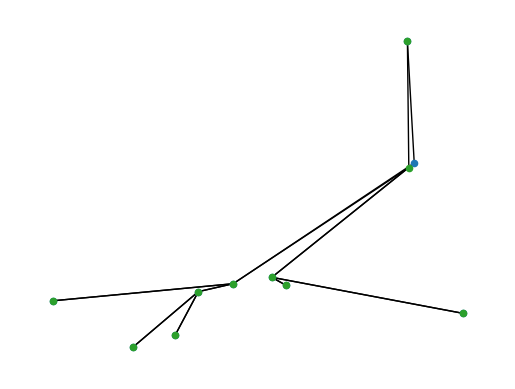

In [427]:
fig, ax = plt.subplots()

graph_vis(solve_graph_new, node_size=20, ax=ax, node_color="tab:blue", arrows=False)
graph_vis(solve_graph_neuron, node_size=20, ax=ax, node_color="tab:green", arrows=False)
plt.show()

In [455]:
fpath = "../jaxley/tests/swc_files"
fname = "morph_multiple_roots.swc"

for fname in os.listdir(fpath):
    if fname.endswith(".swc") and "retina" not in fname:
        print(f"## Checking {fname} ##")

        ### SWC GRAPHS ###
        neuron_swc_reader(os.path.join(fpath, fname))

        swc_old = graph_io_old.to_swc_graph(os.path.join(fpath, fname))
        swc_new = graph_io_new.swc_to_nx(os.path.join(fpath, fname))
        swc_neuron = neuron_swc_graph(os.path.join(fpath, fname))

        ### COMP GRAPHS ###
        solve_graph_neuron = neuron_comp_graph(fname, ncomp=1)

        comp_graph_old = graph_io_old.build_compartment_graph(swc_old, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
        comp_graph_old = graph_io_old._remove_branch_points_at_tips(comp_graph_old)
        solve_graph_old = graph_io_old._remove_branch_points(comp_graph_old)

        comp_graph_new = graph_io_new.build_compartment_graph(swc_new, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
        comp_graph_new = graph_io_new._add_jaxley_meta_data(comp_graph_new)
        solve_graph_new = graph_io_new._replace_branchpoints_with_edges(comp_graph_new)
        nx.set_node_attributes(solve_graph_new, {k: [d.get("soma", False)*"soma" + d.get("basal", False)*"basal" + d.get("apical", False)*"apical" + d.get("axon", False)*"axon"] for k, d in solve_graph_new.nodes(data=True)}, "groups")

        solve_graph_new = match_comps(solve_graph_new, solve_graph_neuron)
        solve_graph_old = match_comps(solve_graph_old, solve_graph_neuron)

        print("Absolute differences:")
        for key in ["radius", "length", "area", "volume"]:
            val = compare_node_attrs(solve_graph_new, solve_graph_neuron, key, func=lambda x, y: jnp.abs(x-y), reduce=None)
            print(f"{key}: {", ".join(f"{n}: {v:.1e}" for n, v in val.items() if v > 1e-4)}")

## Checking morph_interrupted_soma.swc ##


/home/jnsbck/Uni/PhD/projects/jaxleyverse/jaxley/jaxley/io/tmp.py:484: UserWarning: Found a branch with length 0. To avoid NaN while integrating the ODE, we capped this length to 0.1 um. The underlying cause for the branch with length 0 is likely a strange SWC file. The most common reason for this is that the SWC contains a soma traced by a single point, and a dendrite that connects to the soma has no further child nodes.
  "branch with length 0 is likely a strange SWC file. The "


AssertionError: Invalid integration bounds

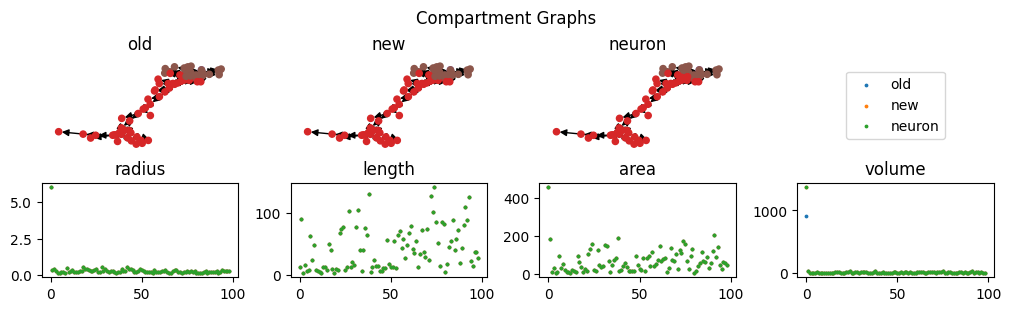

In [313]:
graphs = {"old": solve_graph_old, "new": solve_graph_new, "neuron": solve_graph_neuron}

fig, axd = plt.subplot_mosaic(
    [["old", "new", "neuron", "blank"], ["compare_radius", "compare_length", "compare_area", "compare_volume"]],
    figsize=(10, 3),
    layout="constrained",
)
fig.suptitle("Compartment Graphs")

for name, graph in graphs.items():
    node_attrs = nx.get_node_attributes(graph, "groups")
    node_attrs = {k: v[0] for k, v in node_attrs.items()}

    node_attrs_to_color = {k: f"C{i+3}" for i, k in enumerate(sorted(set(node_attrs.values())))}
    node_colors = [node_attrs_to_color[node_attrs[n]] for n in graph.nodes()]
    graph_vis(graph, node_size=20, node_color=node_colors, ax=axd[name], jitter=0.0)
    axd[name].set_title(name)

for ft in ["radius", "length", "area", "volume"]:
    for name, graph in graphs.items():
        attrs = nx.get_node_attributes(graph, ft)
        axd[f"compare_{ft}"].scatter(*zip(*attrs.items()), label=name, s=3)

    axd[f"compare_{ft}"].set_title(ft)

handles, labels = axd["compare_radius"].get_legend_handles_labels()
axd["blank"].legend(handles, labels, loc="center")
axd["blank"].axis("off")

plt.show()

In [ ]:
# fpath = "../jaxley/tests/swc_files"
# # fname = "morph_retina_20161028_1.swc"

# for fname in os.listdir(fpath):
#     if fname.endswith(".swc"):
#         print(f"## Checking {fname} ##")

#         ### SWC GRAPHS ###
#         neuron_swc_reader(os.path.join(fpath, fname))

#         swc_old = graph_io_old.to_swc_graph(os.path.join(fpath, fname))
#         swc_new = graph_io_new.swc_to_nx(os.path.join(fpath, fname))
#         swc_neuron = neuron_swc_graph(os.path.join(fpath, fname))

#         def get_graph_features(graph, branches):
#             fts = {}

#             # # flatten branch_structure to enable comparison on the branch level, which is most 
#             # # in line with neuron. Two different branches can share the same node.
#             # all_nodes = sum(branches, [])
#             # node_xyzr = np.array([unpack_dict(graph.nodes[n], "xyzr") for n in all_nodes])
#             # fts["node_r"] = node_xyzr[:, 3]
#             # fts["node_xyz_norm"] = np.linalg.norm(node_xyzr[:, :3], axis=1)

#             branch_xyzr = [np.array([unpack_dict(graph.nodes[n], "xyzr") for n in b]) for b in branches]
#             # fts["num_branch_nodes"] = np.array([len(branch) for branch in branches])
#             branch_mean_xyzr = np.array([np.mean(branch, axis=0) for branch in branch_xyzr])

#             branch_center_xyzr = []
#             for xyzr_i in branch_xyzr:
#                 branch_arc_lens = np.concatenate([[0], np.cumsum(np.linalg.norm(np.diff(xyzr_i[:, :3], axis=0), axis=1))])
#                 interp_branch_center = np.apply_along_axis(lambda x: np.interp(0.5, branch_arc_lens, x), 0, xyzr_i)
#                 branch_center_xyzr.append(interp_branch_center)
#             branch_center_xyzr = np.array(branch_center_xyzr)

#             fts["branch_mean_xyz_norm"] = np.linalg.norm(branch_mean_xyzr[:, :3], axis=1)
#             fts["branch_center_xyz_norm"] = np.linalg.norm(branch_center_xyzr[:, :3], axis=1)
#             fts["branch_radii"] = branch_center_xyzr[:, 3]

#             branch_arc_lens = [np.sum(np.linalg.norm(np.diff(np.vstack(x)[:, :3], axis=0), axis=1)) for x in branch_xyzr]
#             fts["branch_len"] = np.array(branch_arc_lens)

#             return fts

#         branches_new = graph_io_new.list_branches(swc_new, ignore_swc_tracing_interruptions=False)
#         branches_old, swc_old = old_list_branches(swc_old, ignore_swc_tracing_interruptions=False)
#         branches_neuron = neuron_list_branches(swc_neuron)

#         branches_new = match_branches(swc_new, swc_neuron, branches_new, branches_neuron)
#         branches_old = match_branches(swc_old, swc_neuron, branches_old, branches_neuron)

#         fts_new = get_graph_features(swc_new, branches_new)
#         fts_old = get_graph_features(swc_old, branches_old)
#         fts_neuron = get_graph_features(swc_neuron, branches_neuron)

#         def print_or_assert(cond, msg, print_only=True):
#             if print_only:
#                 if not cond:
#                     print(msg)
#                 else:
#                     return
#             else:
#                 assert cond, msg

#         for key, vals in fts_neuron.items():
#             is_equal = np.isclose(fts_new[key], vals)
#             print_or_assert(is_equal.all(), f"NEW vs. NEURON: {key} is different for {np.where(~is_equal)[0]}")

#             is_equal = np.isclose(fts_old[key], vals)
#             print_or_assert(is_equal.all(), f"OLD vs. NEURON: {key} is different for {np.where(~is_equal)[0]}")
#         print()

In [158]:
def to_graph(module):
    # TODO: remove glue code
    edges = module.edges.set_index(["pre_index", "post_index"])
    edges.index.names = (None, None)

    G = pandas_to_nx(module.nodes, edges, pd.Series())

    global_attrs = ["xyzr", "channels", "synapses", "group_names", "branch_points_and_tips"]
    for attr in global_attrs:
        G.graph[attr] = getattr(module, attr)

    # G = _replace_edges_with_branchpoints(G) # TODO: fix this
    return G

def set_ncomp(view, ncomp):
    from jaxley.io.graph import branch_comps_from_nodes

    new_branch_comps = []
    for branch_idx in view._branches_in_view:
        branch = view.branch(branch_idx)
        node_attrs = pd.DataFrame(branch.xyzr[0], columns=["x", "y", "z", "r"])
        node_attrs["id"] = 0
        new_comps = branch_comps_from_nodes(node_attrs, ncomp)
        comp_cols = ["is_comp","id", "length", "x", "y", "z", "radius", "area", "volume"]
        comp_df = pd.DataFrame(new_comps, columns=comp_cols)
        comp_df = comp_df.loc[comp_df["is_comp"].astype(bool)].drop(columns=["id", "is_comp"])
        
        for name, is_group in branch.nodes[branch.group_names].all().items():
            comp_df.loc[:, name] = is_group

        comp_df["global_cell_index"] = branch.nodes["global_cell_index"].iloc[0]
        comp_df["global_branch_index"] = branch.nodes["global_branch_index"].iloc[0]
        comp_df["v"] = np.mean(branch.nodes["v"])
        comp_df["axial_resistivity"] = np.mean(branch.nodes["axial_resistivity"])
        comp_df["capacitance"] = np.mean(branch.nodes["capacitance"])
            
        comp_df.index = [-1]*len(comp_df.index)

        new_branch_comps.append(comp_df)

    for branch_idx, branch_comps in zip(view._branches_in_view, new_branch_comps):
        branch_nodes = view.nodes[view.nodes["global_branch_index"] == branch_idx].index
        view.base.nodes = pd.concat([view.base.nodes.loc[:branch_nodes[0]], branch_comps, view.base.nodes.loc[branch_nodes[-1]:]], ignore_index=True, join="outer")
    
    view.base.nodes["global_comp_index"] = np.arange(len(view.base.nodes))
    view.base._init_view()
    view.base._update_local_indices()
    

set_ncomp(cell.branch(0), 5)

In [28]:
# add option for different ncomp per branch in reader

old
       length    radius         x         y          z   groups
17   8.321000  7.914674 -1.431914  3.886156   0.000000   [soma]
18  60.357393  1.009666 -3.381243  8.867996  30.105249  [basal] 


new
       length    radius         x         y          z   soma  basal  apical
66   8.321000  7.939900 -1.431914  3.886156   0.000000   True  False   False
70  60.357393  2.521658 -3.381243  8.867996  30.105249  False   True   False


(-10.0, 15.0)

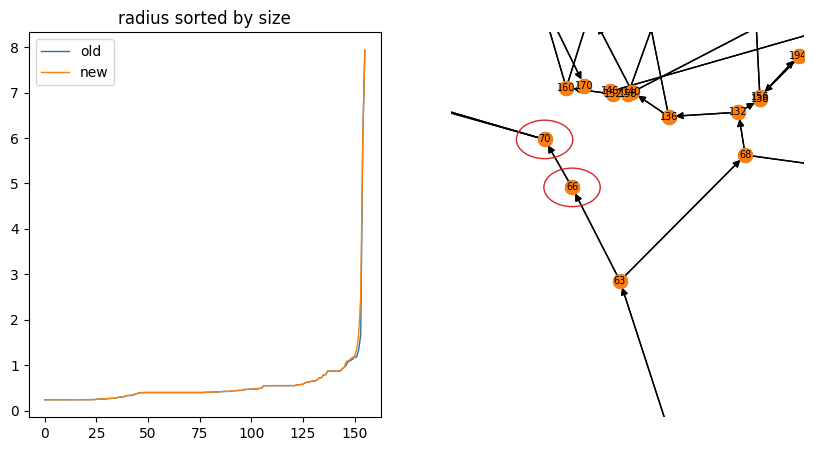

In [34]:
key = "radius"
nx_nodes_df = nx_to_pandas(comp_graph)[0]
nx_vals = nx_nodes_df[key]
jx_vals = jx_nodes_df[key]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(jx_vals.sort_values().values, label="old", lw=1)
ax[0].plot(nx_vals.sort_values().values, label="new", lw=1)
ax[0].set_title(f"{key} sorted by size")
ax[0].legend()
# plt.xlim(0,120)
# plt.ylim(0.2,0.6)

is_close = np.isclose(jx_vals.values[:, None], nx_vals.values, atol=1e-10)

print("old")
print(jx_nodes_df.loc[~is_close.any(axis=1), ["length", "radius", "x", "y", "z", "groups"]].sort_values(by="length"), "\n\n")
print("new")
print(nx_nodes_df.loc[~is_close.any(axis=0), ["length", "radius", "x", "y", "z", "soma", "basal", "apical"]].sort_values(by="length"))

# ----------

swc_coords = {k: (v["x"], v["y"]) for k, v in swc_graph.nodes.items()}
nx_coords = {k: (v["x"], v["y"]) for k, v in comp_graph.nodes.items()}
jx_coords = {k: (v["x"], v["y"]) for k, v in jx_comp_graph.nodes.items()}

# colors = [comp_graph.nodes[n].get("soma", False) for n in comp_graph.nodes]

# nx.draw(swc_graph, pos=swc_coords, with_labels=False, node_size=50, ax=ax[1], font_size=7, node_color="grey", alpha=0.5)
nx.draw(jx_comp_graph, pos=jx_coords, with_labels=False, node_size=100, ax=ax[1], font_size=7, node_color="tab:blue")
nx.draw(comp_graph, pos=nx_coords, with_labels=True, node_size=100, ax=ax[1], font_size=7, node_color="tab:orange")

for i in nx_nodes_df.index[~is_close.any(axis=0)]:
    circle = plt.Circle((nx_coords[i][0], nx_coords[i][1]), 2, color="tab:red", fill=False)
    ax[1].add_artist(circle)

ax[1].set_ylim(-20,20)
ax[1].set_xlim(-10,15)

old
       length    radius          x         y          z   groups
49  57.241291  0.721838  10.858737  7.248406  17.863573  [basal] 


new
       length    radius          x         y          z   soma  basal  apical
58  58.446737  0.799833  10.779451  7.087492  17.288164  False   True   False


(-1.0, 15.0)

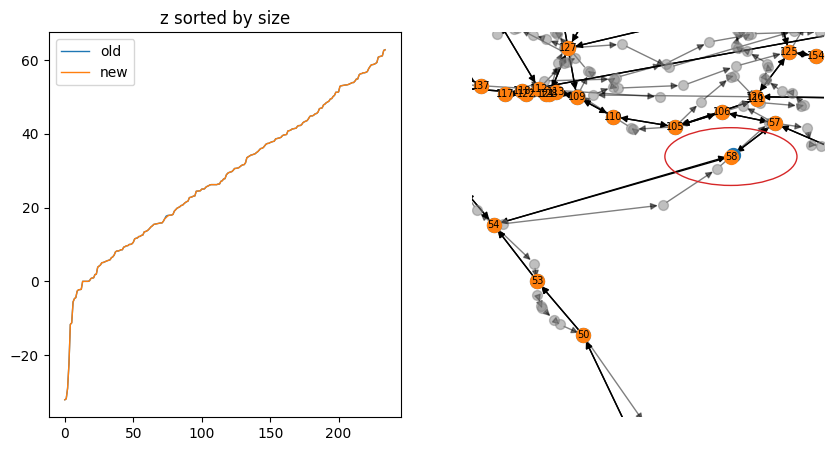

In [266]:
import pickle
from jaxley.io.graph import nx_to_pandas

fname = "morph_ca1_n120"
swc_graph = swc_to_nx(f"../jaxley/tests/swc_files/{fname}.swc")
comp_graph = build_compartment_graph(swc_graph, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph = _add_jaxley_meta_data(comp_graph)

with open(f"{fname}_comp_graph_w_comp_and_branch_index.pkl", "rb") as f:
    jx_comp_graph = pickle.load(f)

jx_nodes_df, jx_edges_df, jx_global_attrs = nx_to_pandas(jx_comp_graph)


# ----------
key = "z"
nx_nodes_df = nx_to_pandas(comp_graph)[0]
nx_vals = nx_nodes_df[key]
jx_vals = jx_nodes_df[key]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(jx_vals.sort_values().values, label="old", lw=1)
ax[0].plot(nx_vals.sort_values().values, label="new", lw=1)
ax[0].set_title(f"{key} sorted by size")
ax[0].legend()
# plt.xlim(0,120)
# plt.ylim(0.2,0.6)

is_close = np.isclose(jx_vals.values[:, None], nx_vals.values, atol=1e-10)

print("old")
print(jx_nodes_df.loc[~is_close.any(axis=1), ["length", "radius", "x", "y", "z", "groups"]], "\n\n")
print("new")
print(nx_nodes_df.loc[~is_close.any(axis=0), ["length", "radius", "x", "y", "z", "soma", "basal", "apical"]])

# ----------

swc_coords = {k: (v["x"], v["y"]) for k, v in swc_graph.nodes.items()}
nx_coords = {k: (v["x"], v["y"]) for k, v in comp_graph.nodes.items()}
jx_coords = {k: (v["x"], v["y"]) for k, v in jx_comp_graph.nodes.items()}

# colors = [comp_graph.nodes[n].get("soma", False) for n in comp_graph.nodes]

nx.draw(swc_graph, pos=swc_coords, with_labels=False, node_size=50, ax=ax[1], font_size=7, node_color="grey", alpha=0.5)
nx.draw(jx_comp_graph, pos=jx_coords, with_labels=False, node_size=100, ax=ax[1], font_size=7, node_color="tab:blue")
nx.draw(comp_graph, pos=nx_coords, with_labels=True, node_size=100, ax=ax[1], font_size=7, node_color="tab:orange")

for i in nx_nodes_df.index[~is_close.any(axis=0)]:
    circle = plt.Circle((nx_coords[i][0], nx_coords[i][1]), 3, color="tab:red", fill=False)
    ax[1].add_artist(circle)

ax[1].set_ylim(-20,20)
ax[1].set_xlim(-1,15)

In [320]:
import numpy as np
import matplotlib.pyplot as plt

def trapz(xp: np.ndarray, fp: np.ndarray, x1: float = None, x2: float = None) -> float:
    """Trapezoidally integrate a function between two points.
    
    Args:
        xp: The x-values of the function.
        fp: The y-values of the function.
        x1: The lower bound of the integration.
        x2: The upper bound of the integration.

    Returns:
        The integral of the function between x1 and x2.
    """
    # Find indices for the segment [x1, x2]
    x1 = xp[0] if x1 is None else x1
    x2 = xp[-1] if x2 is None else x2
    mask = (xp >= x1) & (xp <= x2)
    x_seg = xp[mask]
    fp_seg = fp[mask]

    # Add boundary points if needed
    if x1 not in x_seg:
        r1 = np.interp(x1, xp, fp)
        x_seg = np.insert(x_seg, 0, x1)
        fp_seg = np.insert(fp_seg, 0, r1)

    if x2 not in x_seg:
        r2 = np.interp(x2, xp, fp)
        x_seg = np.append(x_seg, x2)
        fp_seg = np.append(fp_seg, r2)

    # Trapezoidal integration
    integral = np.trapezoid(fp_seg, x_seg)

    return integral

def solid_of_revolution_properties(ls: np.ndarray, rs: np.ndarray, l_start: float = None, l_end: float = None) -> dict:
    """
    Calculate properties of a solid of revolution given length and radius coordinates.
    
    Args:
        ls: array of length coordinates along the path
        rs: array of radius coordinates
        l_start: optional start position for integration (default: min(ls))
        l_end: optional end position for integration (default: max(ls))
    
    Returns:
        dict: Dictionary containing surface_area, volume, and average_radius
    """
    if len(ls) != len(rs):
        raise ValueError("ls and rs must have the same length")
    
    # Set integration bounds
    l_start = ls[0] if l_start is None else l_start
    l_end = ls[-1] if l_end is None else l_end
    
    # Calculate derivatives dr/dl for surface area calculation
    # Use central differences where possible, forward/backward at endpoints
    dr_dl = np.zeros_like(rs)
    
    # Forward difference at start
    dr_dl[0] = (rs[1] - rs[0]) / (ls[1] - ls[0]) if len(rs) > 1 else 0
    
    # Central differences in middle
    for i in range(1, len(rs) - 1):
        dr_dl[i] = (rs[i+1] - rs[i-1]) / (ls[i+1] - ls[i-1])
    
    # Backward difference at end
    if len(rs) > 1:
        dr_dl[-1] = (rs[-1] - rs[-2]) / (ls[-1] - ls[-2])
    
    # a) Surface Area: SA = 2π ∫ r * sqrt(1 + (dr/dl)²) dl
    surface_integrand = 2 * np.pi * rs * np.sqrt(1 + dr_dl**2)
    surface_area = trapz(ls, surface_integrand, l_start, l_end)
    
    # b) Volume: V = π ∫ r² dl
    volume_integrand = np.pi * rs**2
    volume = trapz(ls, volume_integrand, l_start, l_end)
    
    # c) Average Radius: r_avg = ∫ r dl / ∫ dl = ∫ r dl / L
    # where L is the integration length
    radius_integrand = rs
    integration_length = l_end - l_start
    average_radius = trapz(ls, radius_integrand, l_start, l_end) / integration_length
    
    return {
        'area': surface_area,
        'volume': volume,
        'radius': average_radius,
    }

def plot_solid_profile(ls, rs, title="Solid of Revolution Profile"):
    """
    Plot the profile of the solid of revolution.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the profile
    ax1.plot(ls, rs, 'b-o', linewidth=2, markersize=4)
    ax1.fill_between(ls, 0, rs, alpha=0.3)
    ax1.set_xlabel('Length (l)')
    ax1.set_ylabel('Radius (r)')
    ax1.set_title('Profile View')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # Plot the revolution visualization (cross-section)
    theta = np.linspace(0, 2*np.pi, 100)
    max_r = max(rs)
    
    # Show a few cross-sections
    colors = ['red', 'green', 'blue', 'orange']
    for i, (l, r) in enumerate(zip(ls[::len(ls)//4], rs[::len(rs)//4])):
        if i < len(colors):
            x_circle = r * np.cos(theta)
            y_circle = r * np.sin(theta)
            ax2.plot(x_circle, y_circle, color=colors[i], alpha=0.7, 
                    label=f'l={l:.2f}')
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Cross-sections at Different Lengths')
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
# Example 1: Cone (radius decreases linearly)
print("Example 1: Cone")
ls_cone = [0, 1, 2, 3, 4, 5]
rs_cone = [2, 1.6, 1.2, 0.8, 0.4, 0]

results_cone = solid_of_revolution_properties(ls_cone, rs_cone)
print(f"Surface Area: {results_cone['surface_area']:.4f}")
print(f"Volume: {results_cone['volume']:.4f}")
print(f"Average Radius: {results_cone['average_radius']:.4f}")
print(f"Integration Length: {results_cone['integration_length']:.4f}")

# Example 2: Sphere (using half-circle approximation)
print("\nExample 2: Sphere approximation")
n_points = 10
ls_sphere = np.linspace(0, np.pi, n_points)
rs_sphere = np.sin(ls_sphere)  # Unit sphere

results_sphere = solid_of_revolution_properties(ls_sphere, rs_sphere)
print(f"Surface Area: {results_sphere['surface_area']:.4f} (theoretical: {4*np.pi:.4f})")
print(f"Volume: {results_sphere['volume']:.4f} (theoretical: {4*np.pi/3:.4f})")
print(f"Average Radius: {results_sphere['average_radius']:.4f}")

# Example 3: Parabolic shape
print("\nExample 3: Parabolic solid")
ls_parabola = np.linspace(0, 2, 11)
rs_parabola = 1 + 0.5 * ls_parabola**2

results_parabola = solid_of_revolution_properties(ls_parabola, rs_parabola)
print(f"Surface Area: {results_parabola['surface_area']:.4f}")
print(f"Volume: {results_parabola['volume']:.4f}")
print(f"Average Radius: {results_parabola['average_radius']:.4f}")

# Example 4: Partial integration (only part of the parabolic solid)
print("\nExample 4: Partial integration of parabolic solid (l=0.5 to l=1.5)")
results_partial = solid_of_revolution_properties(ls_parabola, rs_parabola, 0.5, 1.5)
print(f"Surface Area: {results_partial['surface_area']:.4f}")
print(f"Volume: {results_partial['volume']:.4f}")
print(f"Average Radius: {results_partial['average_radius']:.4f}")
print(f"Integration bounds: [{results_partial['l_start']:.1f}, {results_partial['l_end']:.1f}]")

# Uncomment to show plots
# plot_solid_profile(ls_cone, rs_cone, "Cone Profile")
# plot_solid_profile(ls_sphere, rs_sphere, "Sphere Profile")
# plot_solid_profile(ls_parabola, rs_parabola, "Parabolic Solid Profile")

Example 1: Cone
Surface Area: 33.8360
Volume: 21.3628
Average Radius: 1.0000
Integration Length: 5.0000

Example 2: Sphere approximation
Surface Area: 14.1769 (theoretical: 12.5664)
Volume: 4.9348 (theoretical: 4.1888)
Average Radius: 0.6301

Example 3: Parabolic solid
Surface Area: 33.8091
Volume: 19.8129
Average Radius: 1.6700

Example 4: Partial integration of parabolic solid (l=0.5 to l=1.5)
Surface Area: 14.2834
Volume: 7.7881
Average Radius: 1.5450
Integration bounds: [0.5, 1.5]


In [339]:
# branch_of = lambda n: solve_graph.nodes[n]["branch_index"]
# is_inter_branch_edge = lambda i, j: solve_graph.edges[i, j]["comp_edge"] and branch_of(i) != branch_of(j)
# branch_edges = [(branch_of(i), branch_of(j)) for (i,j) in solve_graph.edges if is_inter_branch_edge(i, j)]
# branch_graph = nx.DiGraph(branch_edges)

# acc_parents_per_cell = []
# for branches_per_cell in nx.weakly_connected_components(branch_graph):
#     cell_subgraph = branch_graph.subgraph(branches_per_cell)
#     root = next(n for n in cell_subgraph.nodes() if cell_subgraph.in_degree(n) == 0) # assumes each cell has only one root
#     nodes = [root] + [n for n in cell_subgraph.nodes() if n != root]
#     idx = {n: i for i, n in enumerate(nodes)}
#     acc_parents_per_cell += [[idx[next(cell_subgraph.predecessors(n))] if n != root else -1 for n in nodes]]
# acc_parents_per_cell

In [59]:
# # def to_graph(module: jx.Module) -> nx.DiGraph:
# nodes_df = cell.nodes
# synapse_edges = cell.edges
# # edges_df = cell.edges.set_index(["pre_index", "post_index"])
# global_attrs = {"channels": cell.channels, "group_names": cell.group_names, "synapses": cell.synapses, "xyzr": cell.xyzr}

# edges = cell._comp_edges.copy()
# condition1 = edges["type"].isin([2, 3])
# condition2 = edges["type"] == 0
# condition3 = edges["source"] < edges["sink"]
# edges = edges[condition1 | (condition3 & condition2)]
# edges = edges[["source", "sink"]].set_index(["source", "sink"])
# edges.index.names = [None, None]
# edges

In [123]:
# comp_index has to increase along branch, i.e. with node index
# Q1.
#   Should branchpoints have a comp_index?
    # not clear
#   Should comp_index be continuous across the entire module i.e. [0,1,2], [3,4,5] vs [0,1,2], [4,5,6]?
#   Should node_index be continuous across the entire module i.e. [0,1,2], [3,4,5] vs [0,1,2], [4,5,6]?
    # not needed (if loc can be made to work along branch correctly)
# Q2. 
#   Should the nodes (and hence the graph nodes) be ordered somehow, i.e. in depth-first order of the comp edges? Or should the comp_index be the index of the nodes_df?
    # ordering can be determined by ordering of comp_edges
# Q3.
#   Should the comp_index be the index of the nodes_df?
    # no

# Q4. How is solve order determined?
    # solve order is not determined in the reader and just adds a solve index to the nodes_df
# Q5. Is it fine to select relevant_ids in swc_to_nx? Or do we only want to ignore it for branch tracing and give option to add a group still?
    # - [4,4,4,4,2,4,4,4] has to produce 1 branch!
# Q6. keep x,y,z in nodes?
    # needs to be the same as compute_xyz



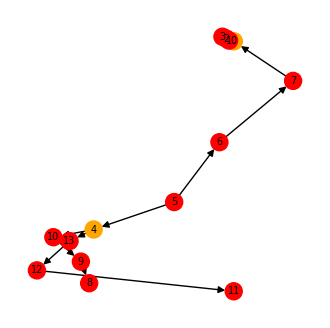

In [138]:
vis_compartment_graph(comp_graph)

In [139]:
comp_graph = _determine_solve_order(comp_graph, source=5)
solve_graph = _replace_branchpoints_with_edges(comp_graph)


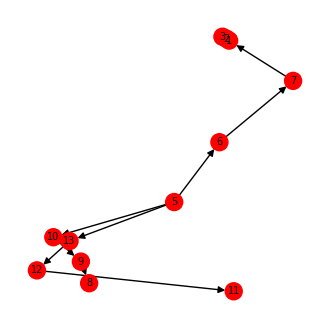

In [140]:
vis_compartment_graph(solve_graph)

In [356]:
from jaxley.io.swc import read_swc as jx_read_swc
from time import perf_counter

testcases = [ 
"morph_3_types.swc",
"morph_interrupted_soma.swc",
"morph_soma_both_ends.swc",
"morph_somatic_branchpoint.swc",
"morph_non_somatic_branchpoint.swc", # no soma!
"morph_ca1_n120.swc",
"morph_l5pc_with_axon.swc",
"morph_3_types_single_point_soma.swc",
"morph_ca1_n120_single_point_soma.swc",
"morph_allen_485574832.swc",
]

for testcase in testcases:
    start = perf_counter()
    jx_cell = jx_read_swc(f"../jaxley/tests/swc_files/{testcase}", ncomp=1)
    end = perf_counter()
    jx_time = end - start
    start = perf_counter()
    new_cell = read_swc(f"../jaxley/tests/swc_files/{testcase}", ncomp=1)
    end = perf_counter()
    new_time = end - start
    print(f"{testcase}: old={new_time:.3f}s | new={jx_time:.3f}s | new is {jx_time/new_time:.1f}x faster")

morph_3_types.swc: old=0.103s | new=0.111s | new is 1.1x faster
morph_interrupted_soma.swc: old=0.100s | new=0.098s | new is 1.0x faster
morph_soma_both_ends.swc: old=0.103s | new=0.107s | new is 1.0x faster
morph_somatic_branchpoint.swc: old=0.103s | new=0.108s | new is 1.0x faster


KeyboardInterrupt: 